In [211]:
import numpy as np
import pandas as pd
import relsolver as rls
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

np.set_printoptions(precision=4, suppress=True)

In [212]:
length_list = np.array([7600, 7700, 7800, 7900,
                        8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900,
                        9000])
force_list = np.array([330000, 340000, 350000,
                       360000, 370000, 380000,
                       390000, 400000])

segment_size = len(force_list)
block_number = len(length_list)
rows_number = block_number * segment_size + 1
rows_numbers_list = np.arange(1, rows_number, 1)

In [213]:
def generate_table ():
    table = get_table_part(length_list[0])
    for i in range(1, block_number):
        table = np.vstack((table, get_table_part(length_list[i])))
    return table

def get_table_part (length_value):
    length_column = get_length_column(length_value, segment_size)
    return np.column_stack((length_column, force_list))

def get_length_column (value, size):
    return(np.linspace(value, value, size))

def set_global_parameters (length, force):
    global_parameters = {"Length": length,
                         "Force": force}
    return global_parameters

def set_global_parameters_by_table_row (table_row):
    global_parameters = {"Length": table_row[0],
                         "Force": table_row[1]}
    return global_parameters

def set_section_parameters (width, height, half_distance):
    section = {"Shelf Width": width,
               "Shelf Height": height,
               "Section Half Distance": half_distance}
    return section

def get_reliability_table_row (reliability_results):
    reliability_table_row = np.array([reliability_results["Safety Feature"],
                                      reliability_results["Malfunction"],
                                      reliability_results["Reliability"]])
    return reliability_table_row

In [214]:
table = generate_table()

In [215]:
section1 = set_section_parameters(150, 9, 92.5)
section2 = set_section_parameters(150, 9, 100)

In [216]:
target_safety_feature = 2.4

In [217]:
iteration_number = 1000

parameters = set_global_parameters_by_table_row(table[0])
parameters.update(section1)
calculation_result = rls.ReliabilityTaskSolve(parameters, iteration_number).get_result()
reliability_table1 = get_reliability_table_row(calculation_result)

for i in range(1, rows_number - 1):
    parameters = set_global_parameters_by_table_row(table[i])
    parameters.update(section1)
    calculation_result = rls.ReliabilityTaskSolve(parameters, iteration_number).get_result()
    reliability_table1 = np.vstack((reliability_table1, get_reliability_table_row(calculation_result)))

parameters = set_global_parameters_by_table_row(table[0])
parameters.update(section2)
calculation_result = rls.ReliabilityTaskSolve(parameters, iteration_number).get_result()
reliability_table2 = get_reliability_table_row(calculation_result)

for i in range(1, rows_number - 1):
    parameters = set_global_parameters_by_table_row(table[i])
    parameters.update(section2)
    calculation_result = rls.ReliabilityTaskSolve(parameters, iteration_number).get_result()
    reliability_table2 = np.vstack((reliability_table2, get_reliability_table_row(calculation_result)))

class1_safety_deviation = abs(reliability_table1[:, 0] - target_safety_feature)
class2_safety_deviation = abs(reliability_table2[:, 0] - target_safety_feature)
target = (class1_safety_deviation < class2_safety_deviation).astype(int)
target = target.reshape(rows_number - 1, 1)

total_table = np.hstack((table, reliability_table1, reliability_table2, target))

In [327]:
columns_names = ["Length, mm", "Force, N",
                 "C1 Safety Feature", "C1 Malfunction", "C1 Reliability",
                 "C2 Safety Feature", "C2 Malfunction", "C2 Reliability",
                 "Target"]
pd_form_total_table = pd.DataFrame(total_table, rows_numbers_list, columns_names)
pd_form_total_table

,"Length, mm","Force, N",C1 Safety Feature,C1 Malfunction,C1 Reliability,C2 Safety Feature,C2 Malfunction,C2 Reliability,Target
1,7600.0,330000.0,4.934601,4.015738e-07,1.000000,5.856021,2.370437e-09,1.000000,1.0
2,7600.0,340000.0,4.348771,6.845142e-06,0.999993,5.424888,2.899541e-08,1.000000,1.0
3,7600.0,350000.0,3.799625,7.245766e-05,0.999928,4.917250,4.388425e-07,1.000000,1.0
4,7600.0,360000.0,3.340737,4.177813e-04,0.999582,4.200077,1.334122e-05,0.999987,1.0
5,7600.0,370000.0,2.910078,1.806691e-03,0.998193,3.851030,5.881097e-05,0.999941,1.0
...,...,...,...,...,...,...,...,...,...
116,9000.0,360000.0,0.580054,2.809390e-01,0.719061,1.914988,2.774705e-02,0.972253,0.0
117,9000.0,370000.0,0.100680,4.599021e-01,0.540098,1.476873,6.985478e-02,0.930145,0.0
118,9000.0,380000.0,-0.206925,5.819656e-01,0.418034,1.062070,1.441020e-01,0.855898,0.0
119,9000.0,390000.0,-0.609885,7.290308e-01,0.270969,0.664602,2.531527e-01,0.746847,0.0


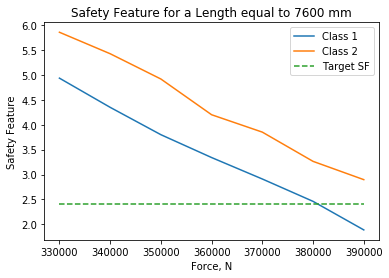

In [311]:
plot_data1 = total_table[0:7, 1:3]
plot_data2 = total_table[0:7, 4:6]
target_SF_list = [2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4]
fig, ax = plt.subplots()
ax.plot(plot_data1[:, 0], plot_data1[:, 1], label="Class 1")
ax.plot(plot_data1[:, 0], plot_data2[:, 1], label="Class 2")
ax.plot(plot_data1[:, 0], target_SF_list, '--', label="Target SF")
ax.set_xlabel("Force, N")
ax.set_ylabel("Safety Feature")
ax.set_title("Safety Feature for a Length equal to 7600 mm")
ax.legend()

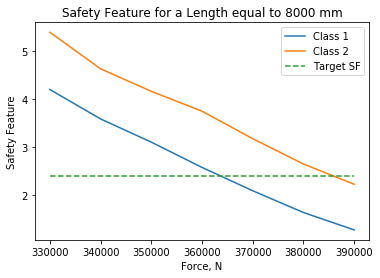

In [321]:
plot_data1 = total_table[32:39, 1:3]
plot_data2 = total_table[32:39, 4:6]
target_SF_list = [2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4]
fig, ax = plt.subplots()
ax.plot(plot_data1[:, 0], plot_data1[:, 1], label="Class 1")
ax.plot(plot_data1[:, 0], plot_data2[:, 1], label="Class 2")
ax.plot(plot_data1[:, 0], target_SF_list, '--', label="Target SF")
ax.set_xlabel("Force, N")
ax.set_ylabel("Safety Feature")
ax.set_title("Safety Feature for a Length equal to 8000 mm")
ax.legend()

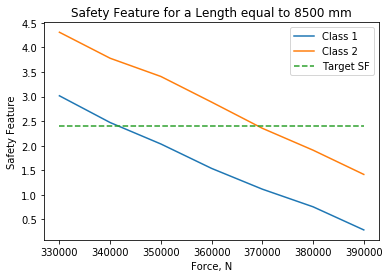

In [324]:
plot_data1 = total_table[72:79, 1:3]
plot_data2 = total_table[72:79, 4:6]
target_SF_list = [2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4]
fig, ax = plt.subplots()
ax.plot(plot_data1[:, 0], plot_data1[:, 1], label="Class 1")
ax.plot(plot_data1[:, 0], plot_data2[:, 1], label="Class 2")
ax.plot(plot_data1[:, 0], target_SF_list, '--', label="Target SF")
ax.set_xlabel("Force, N")
ax.set_ylabel("Safety Feature")
ax.set_title("Safety Feature for a Length equal to 8500 mm")
ax.legend()

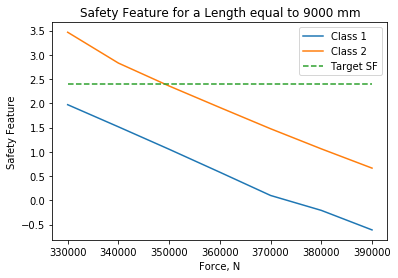

In [326]:
plot_data1 = total_table[112:119, 1:3]
plot_data2 = total_table[112:119, 4:6]
target_SF_list = [2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4]
fig, ax = plt.subplots()
ax.plot(plot_data1[:, 0], plot_data1[:, 1], label="Class 1")
ax.plot(plot_data1[:, 0], plot_data2[:, 1], label="Class 2")
ax.plot(plot_data1[:, 0], target_SF_list, '--', label="Target SF")
ax.set_xlabel("Force, N")
ax.set_ylabel("Safety Feature")
ax.set_title("Safety Feature for a Length equal to 9000 mm")
ax.legend()

In [259]:
X = table
y = target.reshape(1, -1)[0]

clf1 = LogisticRegression()
clf1.fit(X, y)

clf2 = LinearDiscriminantAnalysis()
clf2.fit(X, y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [253]:
def get_class_table_part (class_flag):
    first_row_result = find_first_row_of_class(class_flag)
    res = first_row_result[0]
    start_row = int(first_row_result[1]) + 1
    for i in range(start_row, len(total_table)):
        if total_table[i][8] == class_flag:
            res = np.vstack((res, total_table[i]))
    return res

def find_first_row_of_class (class_flag):
    for i in range(0, len(total_table)):
        if total_table[i][8] == class_flag:
            return (total_table[i], i)
    return "row undefind"

Text(0.5, 1.0, 'Class Diagram')

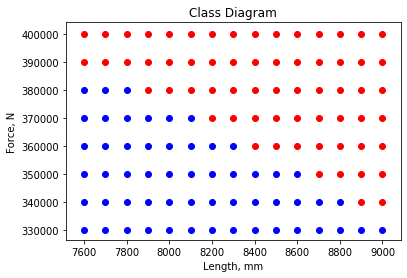

In [329]:
class1_part = get_class_table_part(1)
class2_part = get_class_table_part(0)

fig, ax = plt.subplots()
ax.scatter(class1_part[:, :1], class1_part[:, 1:2], c='blue')
ax.scatter(class2_part[:, :1], class2_part[:, 1:2], c='red')
ax.set_xlabel("Length, mm")
ax.set_ylabel("Force, N")
ax.set_title("Class Diagram")

In [305]:
val_X = np.array([[7600, 375000],
                  [7650, 380000],
                  [7750, 375000],
                  [7850, 375000],
                  [7950, 370000],
                  [8050, 370000],
                  [8150, 365000],
                  [8250, 360000],
                  [8350, 360000],
                  [8450, 355000],
                  [8550, 355000],
                  [8650, 350000],
                  [8750, 345000],
                  [8850, 340000],
                  [8950, 335000],
                  [9000, 335000]])

clf2.predict(val_X)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

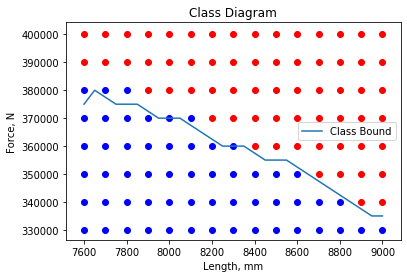

In [334]:
fig, ax = plt.subplots()
ax.scatter(class1_part[:, :1], class1_part[:, 1:2], c='blue')
ax.scatter(class2_part[:, :1], class2_part[:, 1:2], c='red')
ax.plot([7600, 7650, 7750, 7850, 7950, 8050, 8150, 8250, 8350, 8450, 8550, 8650, 8750, 8850, 8950, 9000],
        [375000, 380000, 375000, 375000, 370000, 370000, 365000, 360000, 360000, 355000, 355000, 350000, 345000, 340000,
         335000, 335000], label="Class Bound")
ax.set_xlabel("Length, mm")
ax.set_ylabel("Force, N")
ax.set_title("Class Diagram")
ax.legend()